## Machine Learning
### Linear Regression with MLE
Using __Maximum Likelihood Estimation__ gives a different approach to fit linear models that incorporates the random noise in the data:

- Investigate probability distributions and probabilistic models
- Calculate the likelihood of model parameters
- Implement the maximum likelihood estimator, to find the model parameter with the maximum likelihood

#### Setup
_Import necessary moudules and functions_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# @title Plotting Functions
def plot_density_image(x, y, theta, sigma=1, ax=None):
  """ Plots probability distribution of y given x, theta, and sigma

  Args:

    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta (float): Slope parameter
    sigma (float): standard deviation of Gaussian noise

  """

  # plot the probability density of p(y|x,theta)
  if ax is None:
    fig, ax = plt.subplots()

  xmin, xmax = np.floor(np.min(x)), np.ceil(np.max(x))
  ymin, ymax = np.floor(np.min(y)), np.ceil(np.max(y))
  xx = np.linspace(xmin, xmax, 50)
  yy = np.linspace(ymin, ymax, 50)

  surface = np.zeros((len(yy), len(xx)))
  for i, x_i in enumerate(xx):
    surface[:, i] = stats.norm(theta * x_i, sigma).pdf(yy)

  ax.set(xlabel='x', ylabel='y')

  return ax.imshow(surface, origin='lower', aspect='auto', vmin=0, vmax=None,
            cmap=plt.get_cmap('Wistia'),
            extent=[xmin, xmax, ymin, ymax])

### Maximum Likelihood Estimation
#### Gaussian Noise
Perviously we assumed that the data was drawn from a linear relationship with noise added. Found an effective approach by minimizing the __MSE__.

There we didn't consider the noise in our model, here we will factor it directly. Recall the linear model as:
$$
\begin{align}
y = \theta x + \epsilon.
\end{align}
$$
Noise component $\epsilon$ often modeled as a random variable drawn from a <font color=blue>Gaussian distribution</font>, described by its _probability density function_:
$$
\begin{equation}
p(y|x,\theta) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}(y-\theta x)^2}
\end{equation}
$$
(In other words the probability of observing $y$ given $x$ and parameter $\theta$ is the _PDF_)

It is dependent on two parameters:
- The mean $\mu$
- The variance $\sigma^2$

Often consider noise signal to be Guassian "white noise", with zero mean and unit variance: 
$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Can treat $y$ as a random variable drawn from a Gaussian distribution where $\mu=\theta x$ and $\sigma^2=1$.

(Will focus on a single datapoint, single pairing of $x$ and $y$)

Revisiting the original sample dataset with $\theta=1.2$:

In [4]:
np.random.seed(121)
theta = 1.2
n_samples = 30
x = 10 * np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta * x + noise

Now plotting the density of the _PDF_, see how $p(y)$ changes for varying $x$.

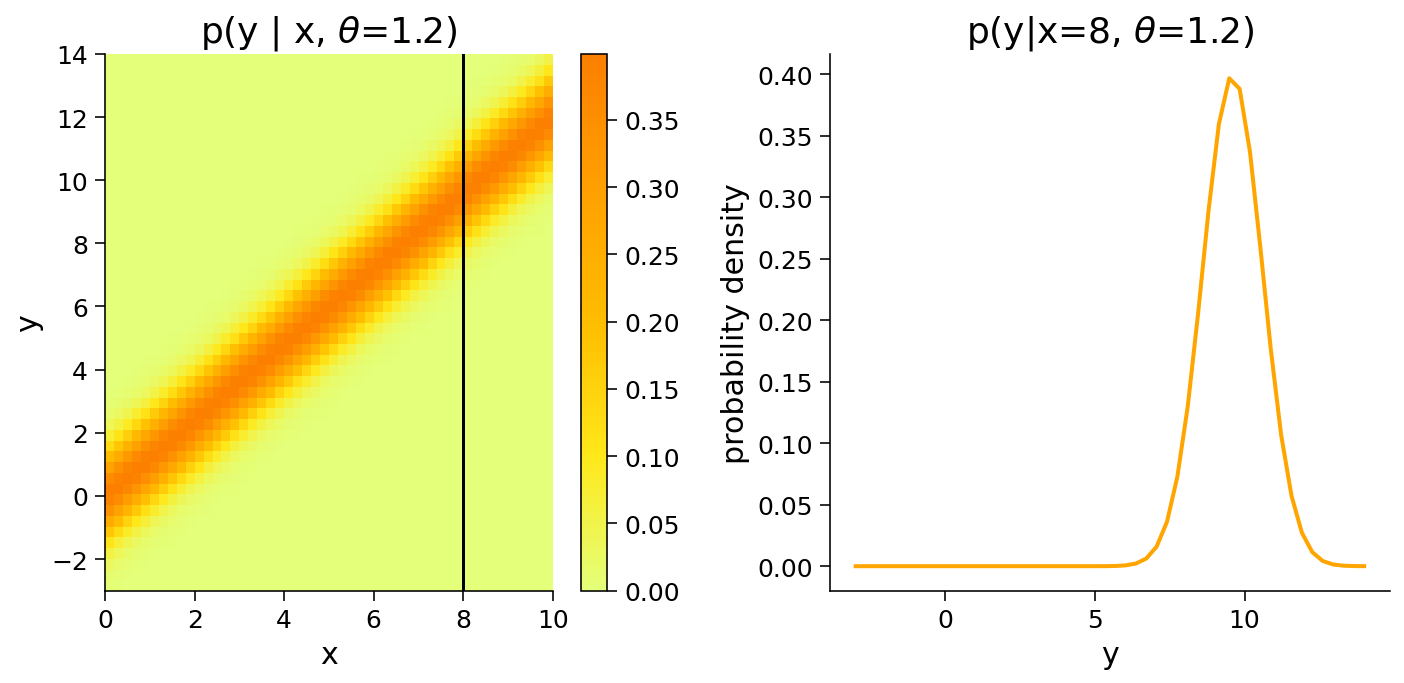

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

# Invokes helper function to generate density image plots from data and parameters
im = plot_density_image(x, y, 1.2, ax=ax1)
plt.colorbar(im, ax=ax1)
ax1.axvline(8, color='k')
ax1.set(title=r'p(y | x, $\theta$=1.2)')

# Plot pdf for given x
ylim = ax1.get_ylim()
yy = np.linspace(ylim[0], ylim[1], 50)
ax2.plot(yy, stats.norm(theta * 8, 1).pdf(yy), color='orange', linewidth=2)
ax2.set(
    title=r'p(y|x=8, $\theta$=1.2)',
    xlabel='y',
    ylabel='probability density')
plt.show()

_PDF_ is centred around $y=10$ from the linear relationship between $x$ and $y$.

### Likelihood Estimation

Now we have a probabilistic model we can approach finding a good estimate for $\theta$ that fits our data. Given inherent uncertainty when dealing in probabilities we reference with _likelihood_ about some $\hat{\theta}$ that fits our data. 

The likelihood function is equal to the _PDF_ paramaterized by that $\theta$:
$$
\begin{equation}
\mathcal{L}(\theta|x,y) = p(y|x,\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{1}{2\sigma^2}(y-\theta x)^2}
\end{equation}
$$
#### Likelihood Function

Implementing the likelihood function for our linear model where $\sigma=1$.

Afterwards can produce probabilities that our estimate $\hat{\theta}$ generated the provided observations.

In [7]:
import math
def likelihood(theta_hat, x, y):
  """The likelihood function for a linear model with noise sampled from a
    Gaussian distribution with zero mean and unit variance.

  Args:
    theta_hat (float): An estimate of the slope parameter.
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray: the likelihood values for the theta_hat estimate
  """
  sigma = 1

  # Compute Gaussian likelihood
  pdf = (1/np.sqrt(2*math.pi))*np.exp((-1/2)*(y-x)**2)

  return pdf


print(likelihood(1.0, x[1], y[1]))

0.11344443599846923


How does this tell us how this estimate is better than any others?

When dealing with a _set_ of data points we are concerned with their joint probability - likelihood that all data points are explained by our paramaterization. Having assumed noise affects each output independently, can factorize the likelihood:
$$
\begin{equation}
\mathcal{L}(\theta|\mathbf{x}, \mathbf{y}) = \prod_{i=1}^N \mathcal{L}(\theta|x_i,y_i),
\end{equation}
$$
Where we have $N$ data points.

Practically such a product can be numerically unstable. Multiplying small values together can lead to <font color=orange>arithmetic underflow</font>, the situation in which the digital representation of a floating point number reaches its limit.

Can circumvent this problem by taking the logarithm of the likelihood:
$$
\begin{equation}
\log\mathcal{L}(\theta|\mathbf{x}, \mathbf{y}) = \sum_{i=1}^N \log\mathcal{L}(\theta|x_i,y_i)
\end{equation}
$$

We can take the sum of the log of the output of our likelihood method applied to the full dataset to get a better idea of how different $\hat{\theta}$ compare. We can also plot the different distribution densities over our dataset and see how they line up qualitatively.

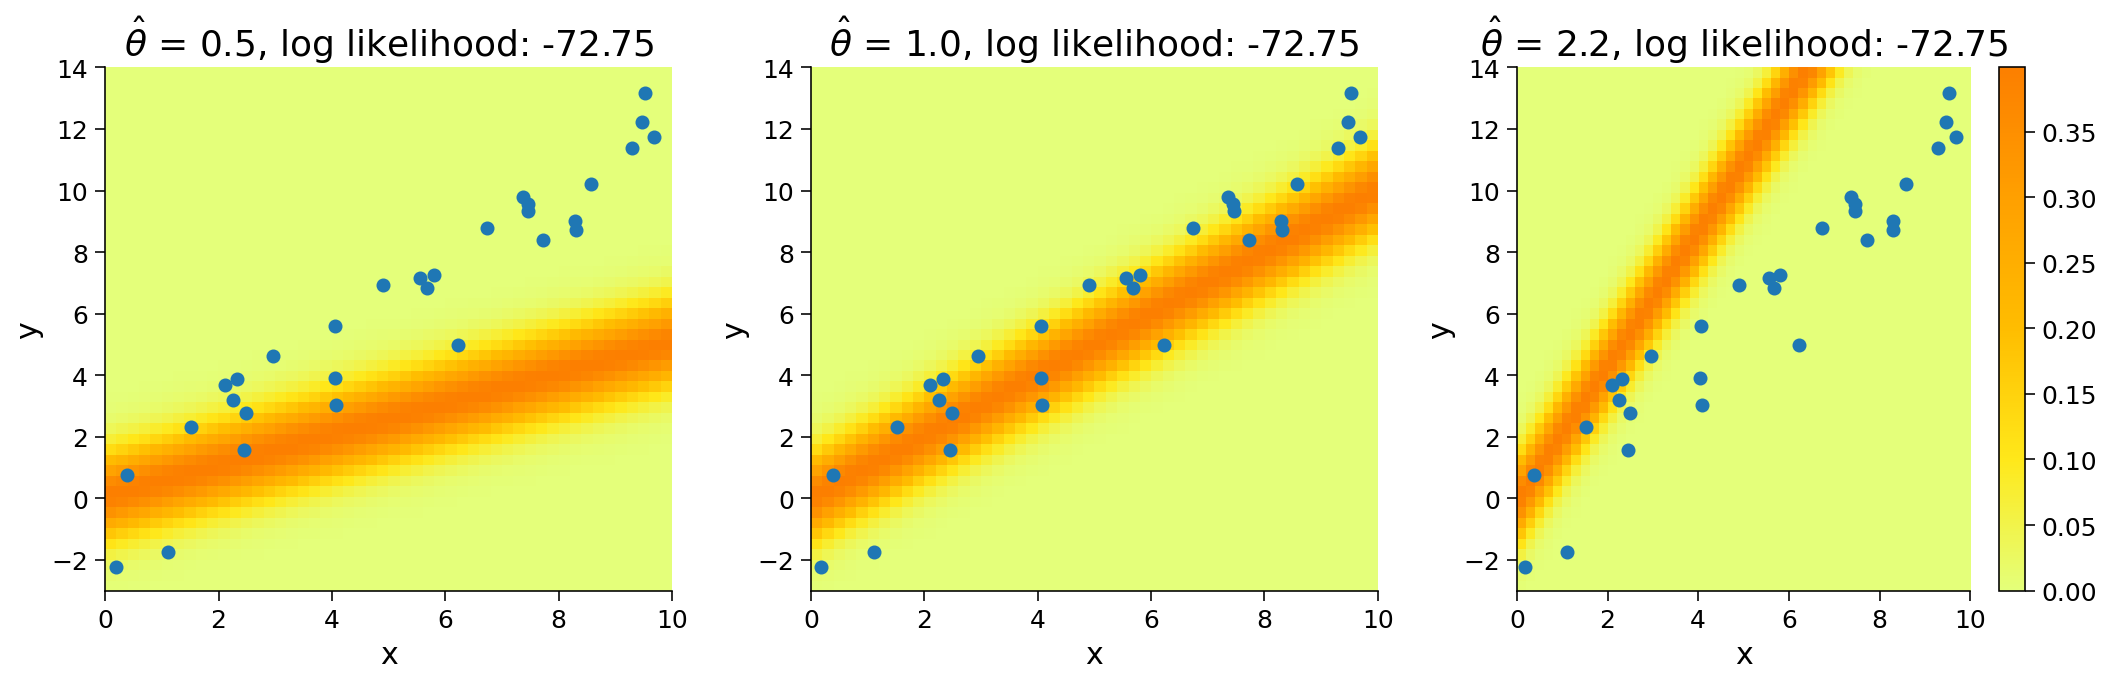

In [8]:
theta_hats = [0.5, 1.0, 2.2]
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for theta_hat, ax in zip(theta_hats, axes):
  ll = np.sum(np.log(likelihood(theta_hat, x, y)))  # log likelihood
  im = plot_density_image(x, y, theta_hat, ax=ax)
  ax.scatter(x, y)
  ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat}, log likelihood: {ll:.2f}')
plt.colorbar(im, ax=ax)
plt.show()

Using Log likelihood calculation, see that: $\mathcal{L}(\theta=1.0) > \mathcal{L}(\theta=0.5) > \mathcal{L}(\theta=2.2)$

Now we have a way to compare estimators based on likelihood. But like with the MSE approach, we want an analytic solution to find the best estimator. In this case, we want to find the estimator that maximizes the likelihood.

### Finding the Maximum Likelihood Estimator

We want to find the parameter value $\hat{\theta}$ that makes our data set the most likely estimation:
$$
\begin{align}
\hat{\theta}_{\textrm{MLE}} = \underset{\theta}{\operatorname{argmax}} \mathcal{L}(\theta|X,Y)
\end{align}
$$
Taking the logarithm helps numerical stability and doesn't change the parameter value that maximizes the likelihood. The $log()$ function is _monotonically increasing_, it preserves the order of its inputs. So:
$$
\begin{align}
\hat{\theta}_{\textrm{MLE}} = \underset{\theta}{\operatorname{argmax}} \sum_{i=1}^m \textrm{log} \mathcal{L}(\theta|x_i,y_i)
\end{align}
$$
Note that maximizing the log likelihood is the same as minimizing the negative log likelihood (in practice optimization routines are developed to solve minimization not maximization problems). Because of the convexity of this objective function, we can take the derivative of our negative log likelihhood, set it to 0, and solve - just like our solution to minimizing MSE.
$$
\begin{align}
\frac{\partial\operatorname{log}\mathcal{L}(\theta|x,y)}{\partial\theta}=\frac{1}{\sigma^2}\sum_{i=1}^N(y_i-\theta x_i)x_i = 0
\end{align}
$$
This looks remarkably like the equation we had to solve for the optimal MSE estimator, and, in fact, we arrive to the exact same solution!
$$
\begin{align}
\hat{\theta}_{\textrm{MLE}} = \hat{\theta}_{\textrm{MSE}} = \frac{\sum_{i=1}^N x_i y_i}{\sum_{i=1}^N x_i^2}
\end{align}
$$

Computing $\hat{\theta}_{\textrm{MLE}}$ and plotting the resulting distribution density:

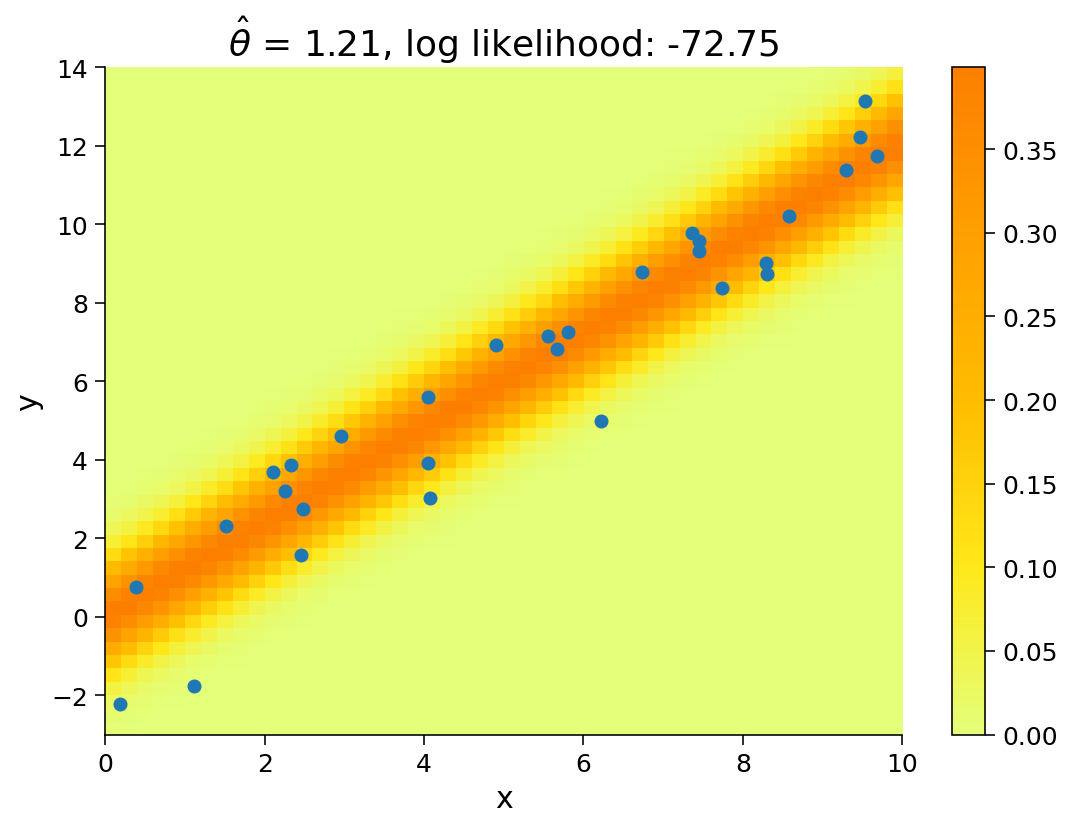

In [9]:
# Compute theta_hat_MLE
theta_hat_mle = (x @ y) / (x @ x)

# Plot the resulting distribution density
fig, ax = plt.subplots()
ll = np.sum(np.log(likelihood(theta_hat_mle, x, y))) # log likelihood
im = plot_density_image(x, y, theta_hat_mle, ax=ax)
plt.colorbar(im, ax=ax)
ax.scatter(x, y)
ax.set(title=fr'$\hat{{\theta}}$ = {theta_hat_mle:.2f}, log likelihood: {ll:.2f}')
plt.show()

### Summary
Likelihood vs Probability:
- $\mathcal{L}(\theta|x, y) = p(y|x, \theta)$
- $p(y|x, \theta) \rightarrow$ "probability of observing the response $y$ given parameter $\theta$ and input $x$"
- $\mathcal{L}(\theta|x, y) \rightarrow$ "likelihood model that parameters $\theta$ produced response $y$ from input $x$"

Log-likelihood maximization:
- We take the $log$ of the likelihood function for computational convenience
- The parameters $\theta$ that maximize $\log\mathcal{L}(\theta|x, y)$ are the model parameters that maximize the probability of observing the data.

__Key point__: the log-likelihood is a flexible cost function, and is often used to find model parameters that best fit the data.